In [ ]:
# Source : Séminaire "Paléographie computationnelle", Ecole des Chartes, 2024-2025

In [17]:
import os
import torch
import torchvision.transforms as T
from torchvision.models import resnet50
from tqdm import tqdm
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#src = str(Path.cwd().resolve().parents[0]/ 'src')
#sys.path.append(src)
#from config.paths import ROOT, DATA, EXPERIMENTS, DOC_IMGS, CLEANED, PROCESSED, METADATA

In [23]:
DATA = '/content/drive/MyDrive/dataHN/data'
EXPERIMENTS = '/content/drive/MyDrive/dataHN/experiments'
experiment_dir = os.path.join(EXPERIMENTS, 'resnet_masks_cluster')
os.makedirs(experiment_dir, exist_ok=True)

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = resnet50(weights='IMAGENET1K_V1')
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()
model.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
crops_masks_dir = os.path.join(DATA, 'segmented', 'sam2_masks_crops' )
mask_paths = [
    os.path.join(root, f)
    for root, _, files in os.walk(crops_masks_dir)
    for f in files
    if f.lower().endswith(('png'))
]

print(f"Total : {len(mask_paths)} masques")

Total : 9832 masques


In [ ]:

def load_and_preprocess_images(image_path_list, model, device, target_size=(224,224)):
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize(target_size),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])

    feature_list = []
    image_paths = []

    for img_path in tqdm(image_path_list, desc="Processing images"):
        if not img_path.lower().endswith(('png','jpg','jpeg')):
            continue

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        img = cv2.resize(img, target_size)
        img_stack = np.stack([img]*3, axis=-1)

        img_tensor = transform(img_stack).unsqueeze(0).to(device)
        with torch.no_grad():
            features = model(img_tensor)
            features = features.view(features.size(0), -1)
            feature_list.append(features.cpu().numpy().flatten())
            image_paths.append(img_path)

    return np.array(feature_list), image_paths

In [ ]:

def reduce_dimensionality(features, n_components=2):
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features)
    return features_pca, pca

In [ ]:

def cluster_images(features_pca, n_clusters, method='kmeans'):
    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=42)
    elif method == 'dbscan':
        model = DBSCAN(eps=5, min_samples=2)
    labels = model.fit_predict(features_pca)
    return labels

In [ ]:

def plot_scatter(features_2d, labels):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

In [ ]:

def visualize_all_clusters(image_paths, labels, max_images_per_cluster=100):
    unique_labels = np.unique(labels)
    for label in sorted(unique_labels):
        idxs = np.where(labels == label)[0]
        n_images = min(len(idxs), max_images_per_cluster)
        cols = 10
        rows = int(np.ceil(n_images / cols))
        plt.figure(figsize=(3*cols,3*rows))
        for i, idx in enumerate(idxs[:n_images]):
            img = cv2.imread(image_paths[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(rows, cols, i+1)
            plt.imshow(img)
            plt.axis('off')
        plt.suptitle(f'Cluster {label} - Showing {n_images} Images', fontsize=16)
        plt.tight_layout()
        plt.show()

In [25]:
def get_clusters_dict(image_paths, labels):

    clusters = {}

    for path, label in zip(image_paths, labels):
        img_file = os.path.basename(path)
        img_file = os.path.splitext(img_file)[0]
        label = int(label)  # ensure plain Python int
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(img_file)

    return clusters

In [ ]:
features_array, image_paths_list = load_and_preprocess_images(mask_paths, model, device)

Processing images: 100%|██████████| 9832/9832 [22:52<00:00,  7.16it/s]


In [ ]:

results_dir = os.path.join(DATA, 'embeddings', 'resnet')
os.makedirs(results_dir, exist_ok=True)

np.savez_compressed(os.path.join(results_dir,"mask_features.npz"), features=features_array, paths=np.array(image_paths_list))


In [ ]:
# data = np.load(os.path.join(results_dir, "mask_features.npz"), allow_pickle=True)
# features_array = data["features"]
# image_paths_list = data["paths"].tolist()

In [14]:
features_pca, pca = reduce_dimensionality(features_array)

In [15]:
labels = cluster_images(features_pca, n_clusters=10, method='kmeans')

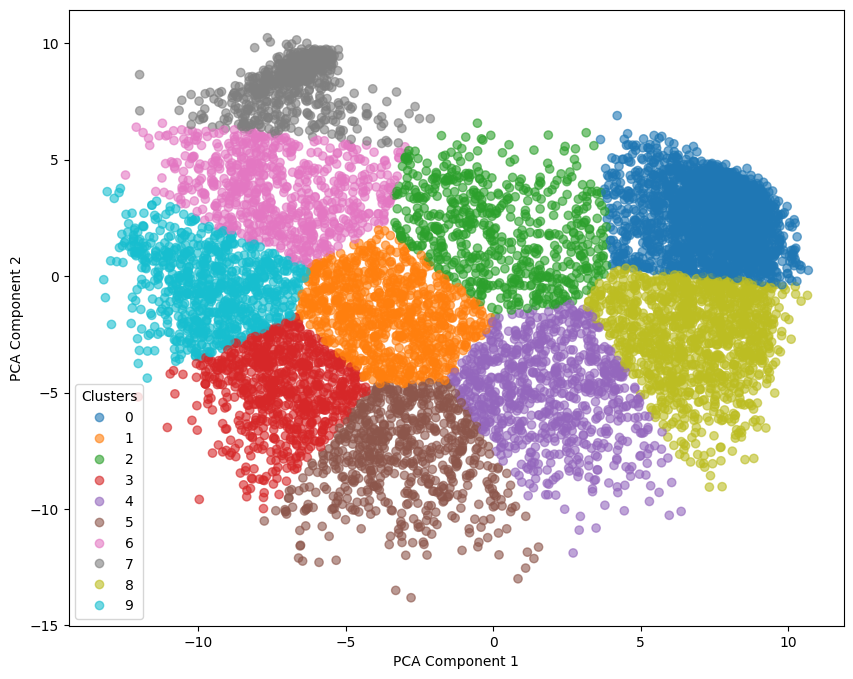

In [ ]:
plot_scatter(features_pca, labels)

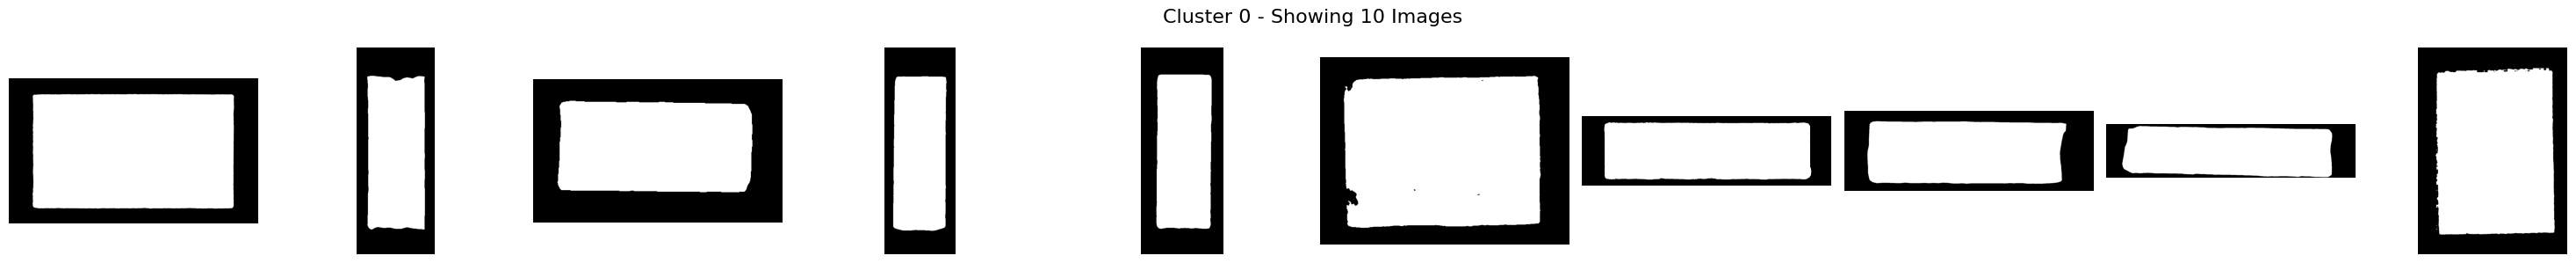

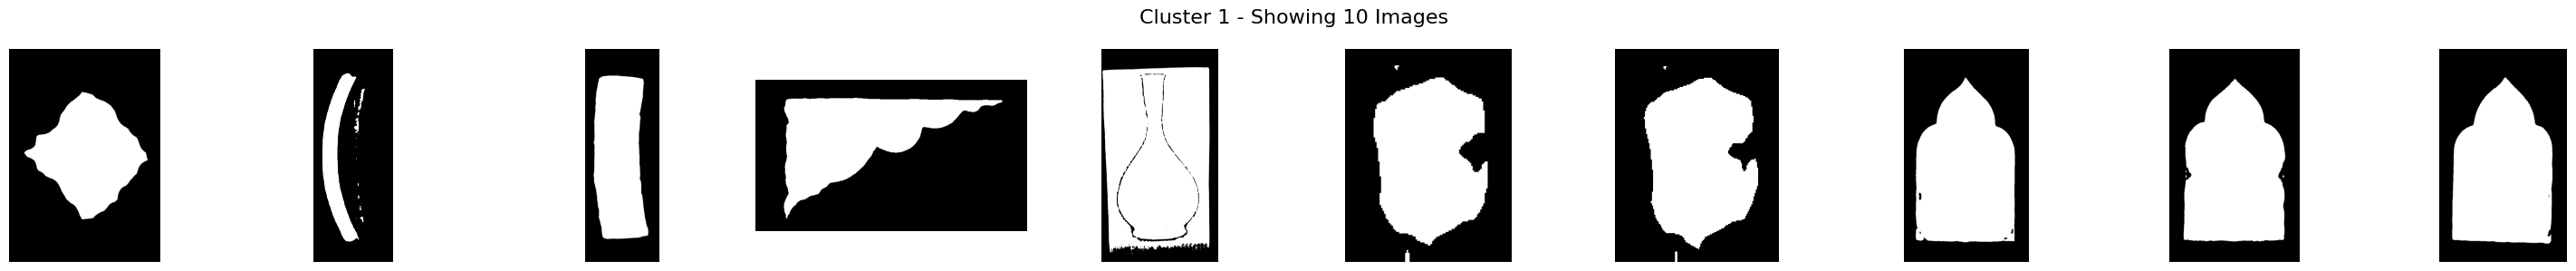

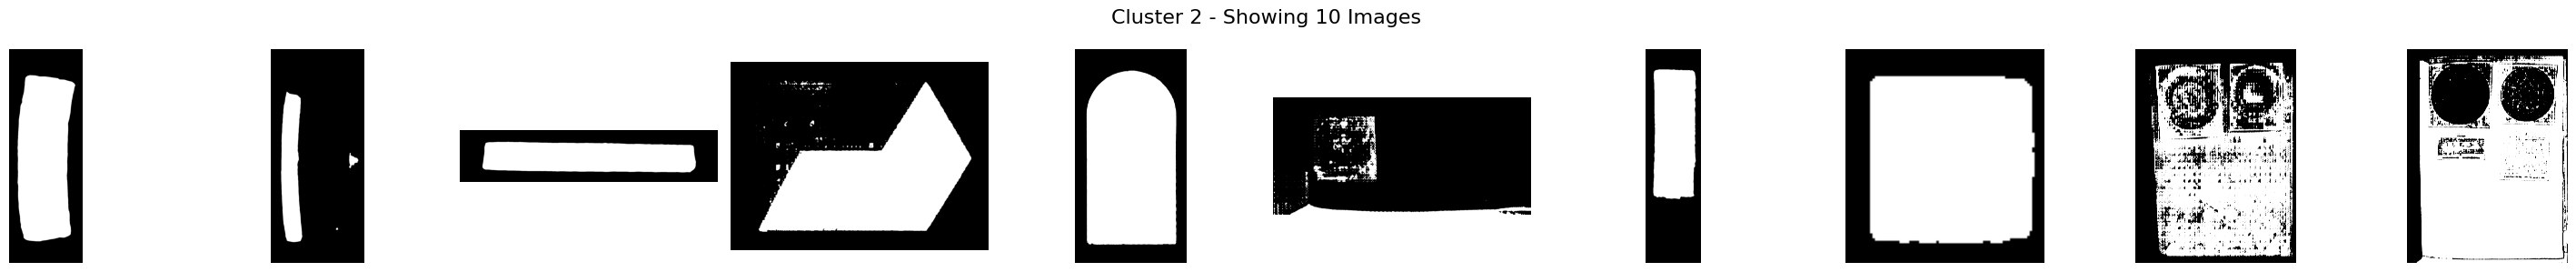

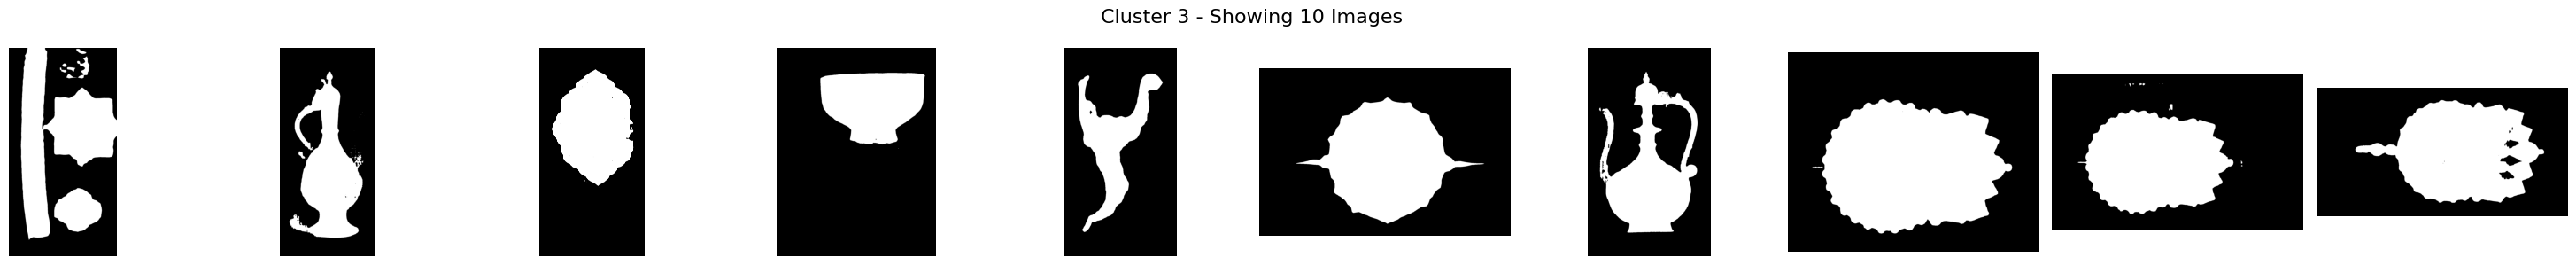

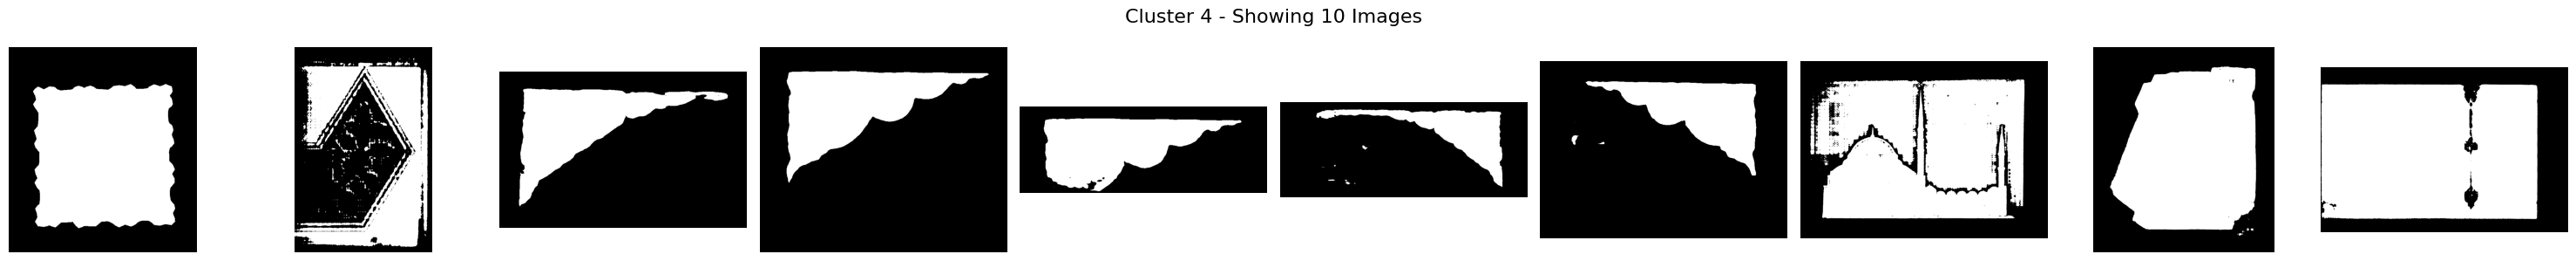

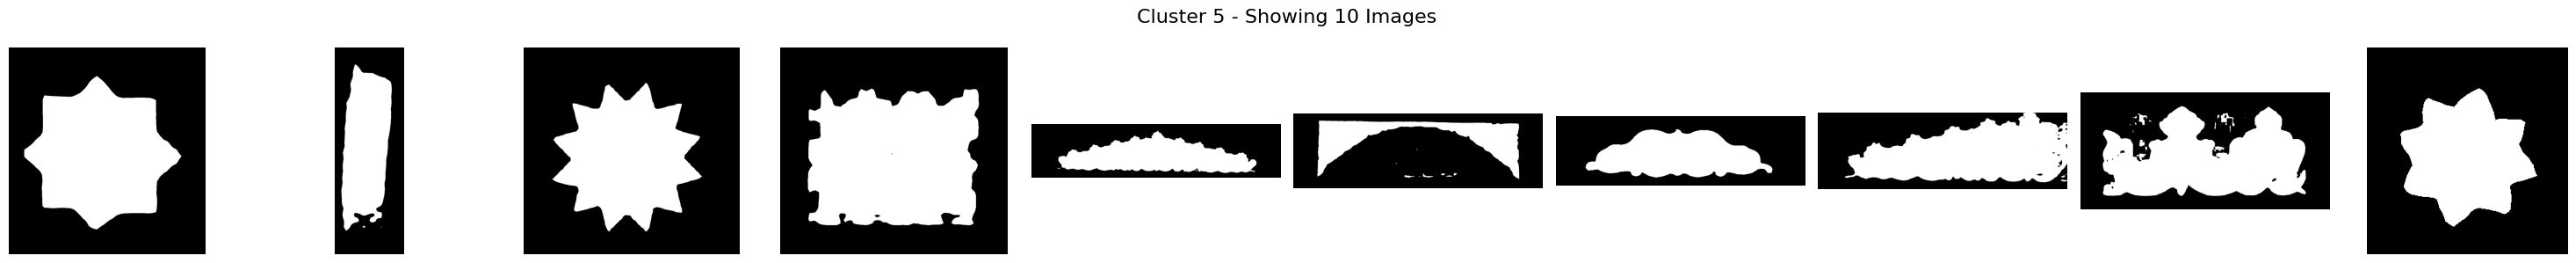

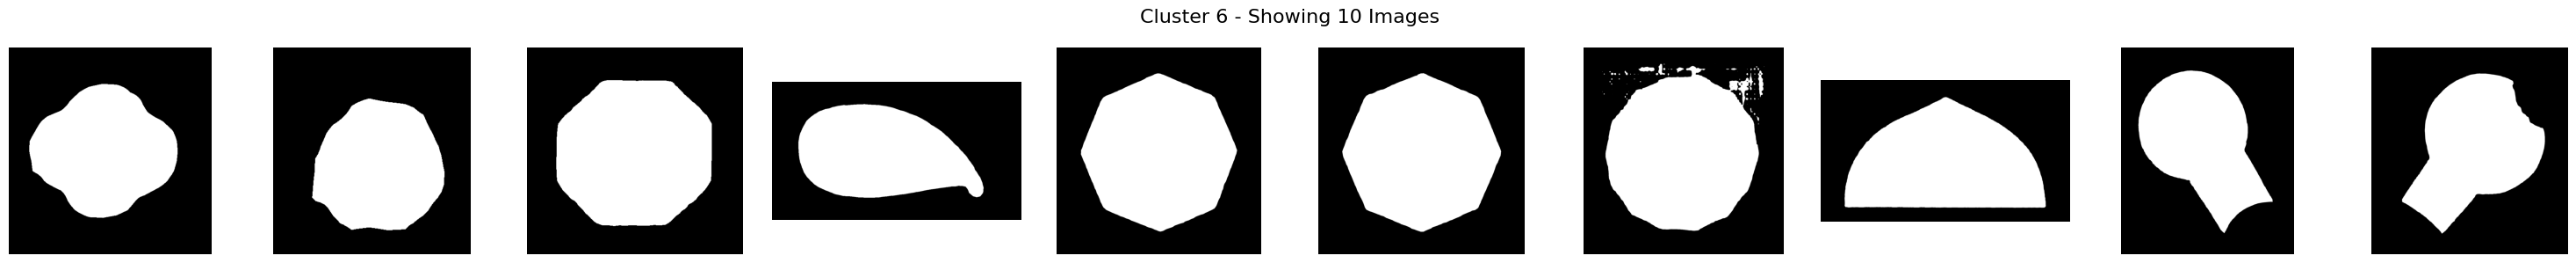

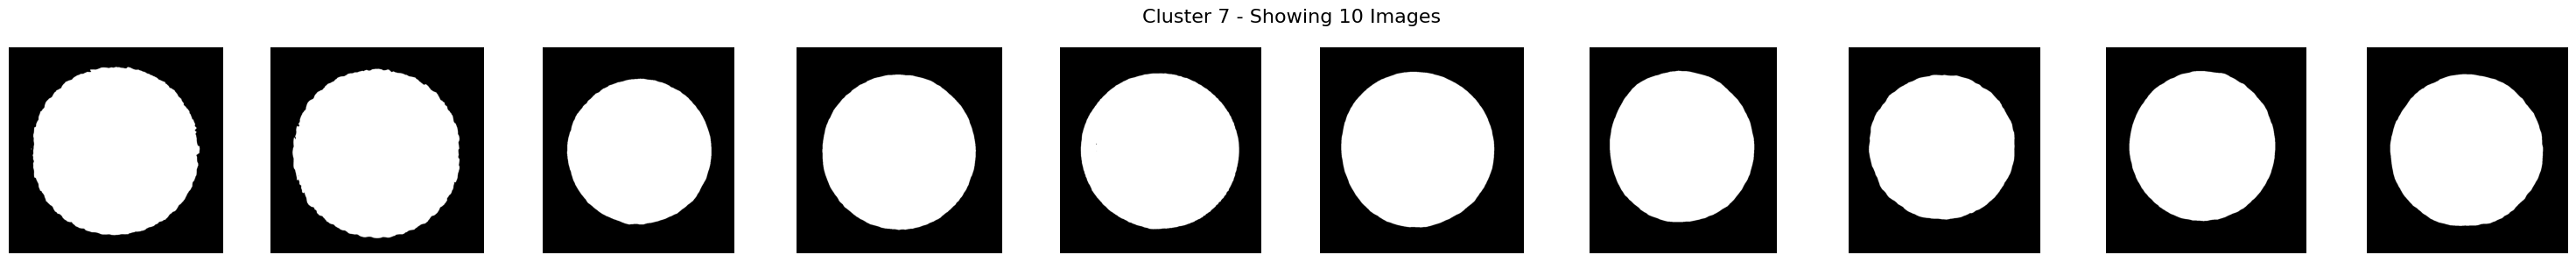

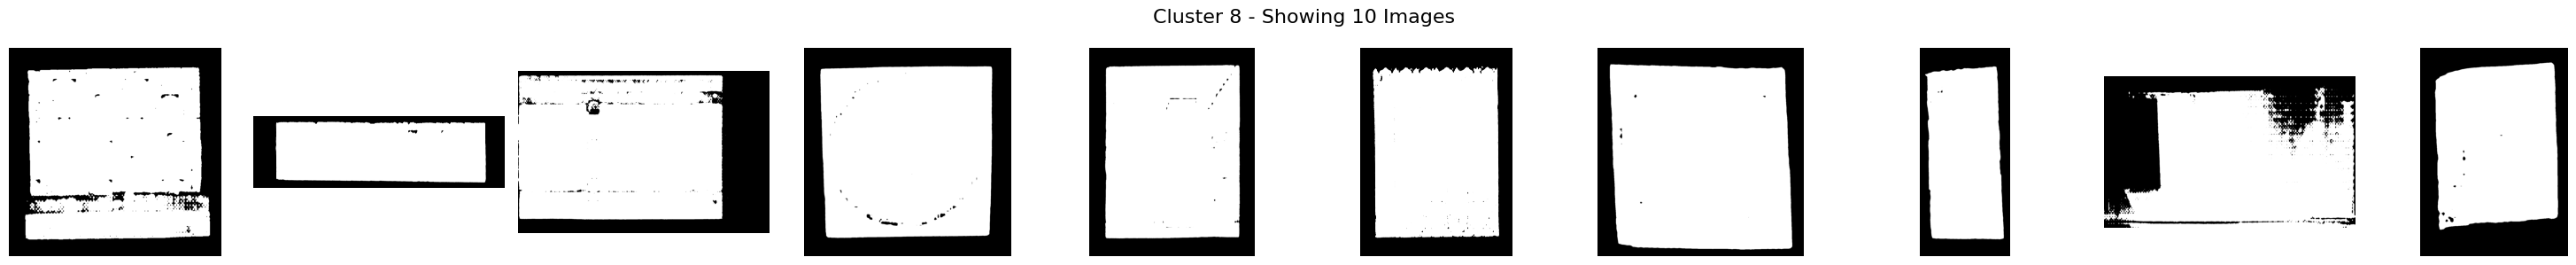

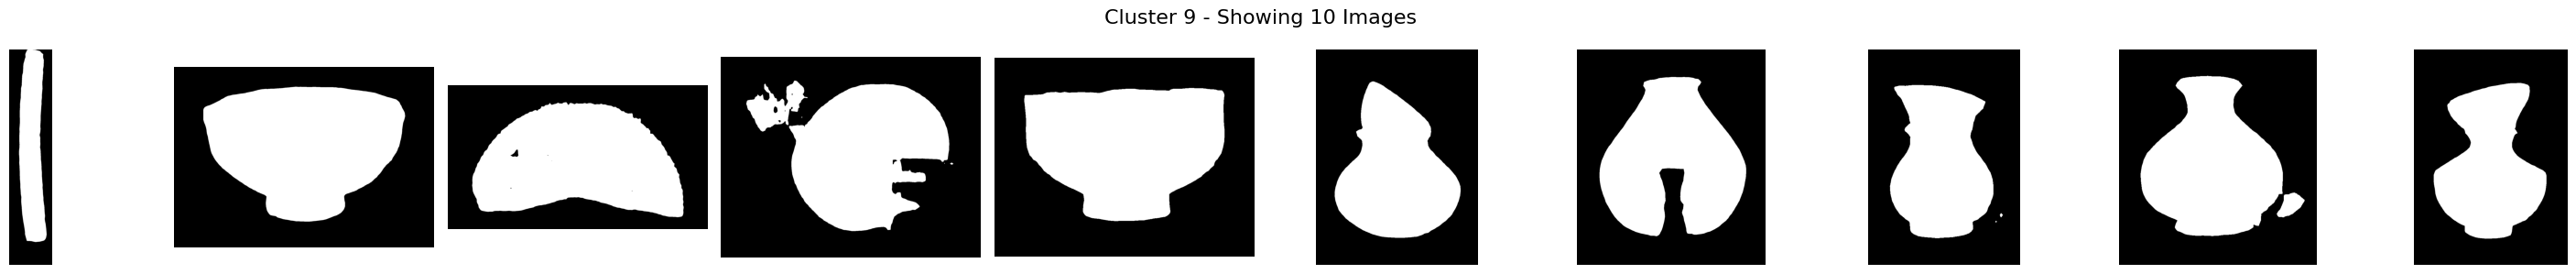

In [ ]:
visualize_all_clusters(image_paths_list, labels, max_images_per_cluster=10)

In [ ]:
labels_docs = cluster_images(features_pca, n_clusters=10, method='dbscan')

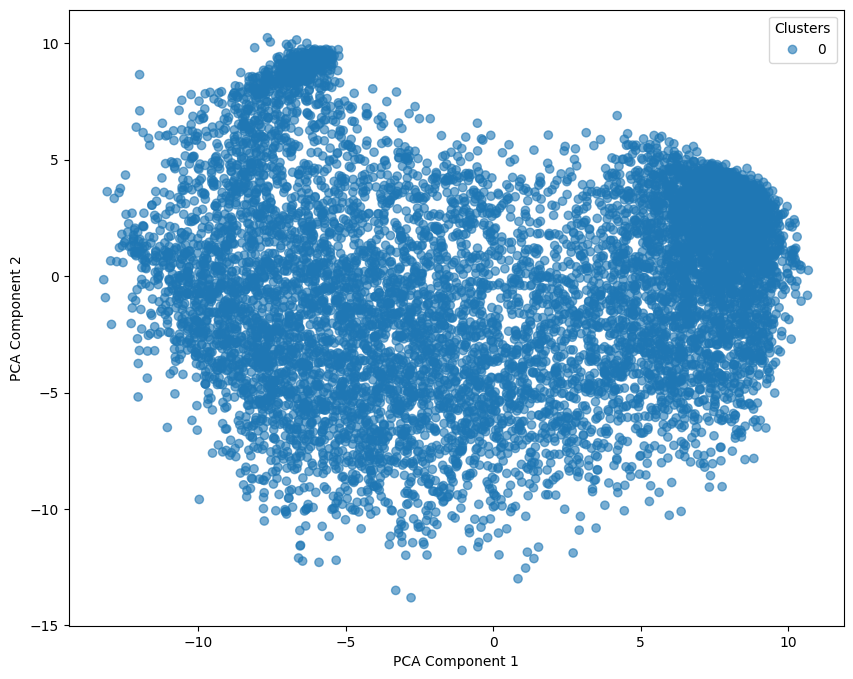

In [ ]:
plot_scatter(features_pca, labels_docs)

In [26]:
dico_clusters = get_clusters_dict(image_paths_list, labels)

In [29]:
with open(os.path.join(experiment_dir, "masks_clusters.json"), 'w', encoding='UTF-8') as f :
    json.dump(dico_clusters, f)